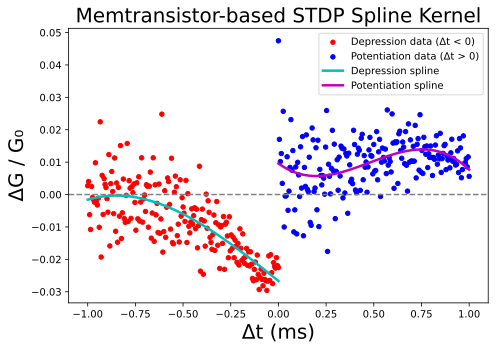

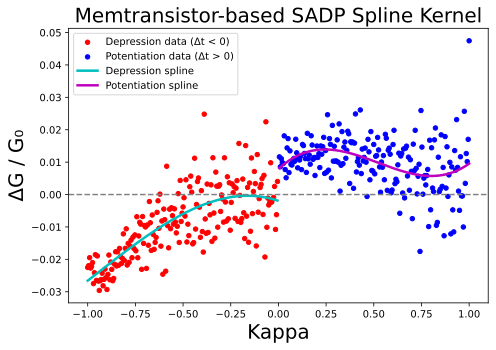

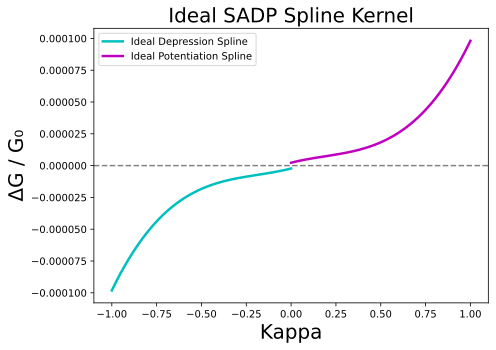

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score
%run SADP_functions.ipynb

In [2]:
# ---------------- HELPERS ----------------
def extract_spike_count_features(model, x_spike, batch_size=128, timesteps=10):
    """
    Run the SNN model on spike-encoded inputs and return spike-count features.
    Assumes the SNN model returns output with shape (N, neurons, timesteps) or (N, timesteps, neurons).
    Returns:
      features: np.array shape (N, neurons) = spike counts per neuron across timesteps
      raw: raw output array shape (N, neurons, timesteps)
    """
    out = model.predict(x_spike, batch_size=batch_size, verbose=0)
    if tf.is_tensor(out):
        out = out.numpy()
    if out.ndim != 3:
        raise ValueError(f"Expected 3D output from SNN (N,neurons,timesteps) or (N,timesteps,neurons). Got shape {out.shape}")
    # If shape is (N, timesteps, neurons), swap
    if out.shape[1] == timesteps and out.shape[2] != timesteps:
        out = np.transpose(out, (0, 2, 1))  # -> (N, neurons, timesteps)
    # Sum over timesteps to get spike-count per neuron
    spike_counts = out.sum(axis=-1)  # (N, neurons)
    return spike_counts, out

def safe_unpack_sadp_return(sadp_ret, total_wall_time, epochs):
    """
    Accept flexible SADP return types.
    Preferred SADP return: (w_norms_list, per_epoch_times_list)
    If only w_norms_list is returned, compute avg epoch time = total_wall_time / epochs.
    Returns (w_norms_list, per_epoch_times_list)
    """
    # Default fallback
    avg_epoch = total_wall_time / epochs if epochs > 0 else total_wall_time
    if sadp_ret is None:
        return [], [avg_epoch] * epochs

    # If it's a tuple/list with two elements and second is list-like -> interpret directly
    if isinstance(sadp_ret, (tuple, list)) and len(sadp_ret) == 2:
        w_norms, per_epoch_times = sadp_ret
        # If the second is a scalar (unexpected), fallback
        if np.isscalar(per_epoch_times):
            per_epoch_times = [float(per_epoch_times)] * epochs
        return list(w_norms), list(per_epoch_times)

    # If it's list/array -> treat as w_norms only
    if isinstance(sadp_ret, (list, np.ndarray)):
        return list(sadp_ret), [avg_epoch] * epochs

    # Otherwise unknown -> fallback empty
    return [], [avg_epoch] * epochs

# ---------------- BENCHMARK RUNNER ----------------
def run_full_benchmark(encoding_name, model_type, sadp_method):
    print(f"\n=== Testing {encoding_name} | {model_type} | {sadp_method.__name__} ===")

    # 1) Spike encoding function
    encode_fn = rate_coding if encoding_name == 'rate' else ttfs_coding
    x_train_spike = encode_fn(x_train, timesteps)  # expected shape depends on your SNN input
    x_test_spike  = encode_fn(x_test, timesteps)

    # Convert to tf tensors only if your model expects them (many do)
    x_train_spike_tf = tf.convert_to_tensor(x_train_spike)
    x_test_spike_tf  = tf.convert_to_tensor(x_test_spike)

    # 2) Build SNN
    if model_type == '1layer_small':
        model = build_snn_1layer_small(num_timesteps=timesteps)
    elif model_type == '1layer':
        model = build_snn_1layer(num_timesteps=timesteps)
    else:
        raise ValueError("Unknown model_type: " + str(model_type))

    # Force build by running a single sample if necessary
    try:
        _ = model(x_train_spike_tf[:1])
    except Exception:
        # Some SNN models might not take TF tensors; try numpy
        try:
            _ = model(x_train_spike[:1])
        except Exception:
            pass

    # 3) Prepare SADP args
    sadp_args = {
        'model': model,
        'x_train': x_train_spike_tf,
        'y_train': (rate_code_labels(y_train_cat, timesteps) if encoding_name == 'rate'
                    else ttfs_code_labels(y_train_cat, timesteps)),
        'epochs': sadp_epochs,
        'batch_size': batch_size,
        'learning_rate': sadp_lr,
        'V_thresh': V_thresh
    }
    if sadp_method.__name__ == 'train_on_chip_spline':
        sadp_args.update({'spline_pot': spline_pot, 'spline_dep': spline_dep})
    elif sadp_method.__name__ == 'train_on_chip_spline_ideal':
        sadp_args.update({'spline_pot_ideal': spline_pot_ideal, 'spline_dep_ideal': spline_dep_ideal})

    # 4) Run SADP and time
    t0 = time.time()
    sadp_ret = sadp_method(**sadp_args)  # user-provided function; prefer returning (w_norms, per_epoch_times)
    total_sadp_time = time.time() - t0

    # Unpack SADP return safely
    w_norms, per_epoch_times = safe_unpack_sadp_return(sadp_ret, total_sadp_time, sadp_epochs)
    # ensure lengths
    if len(per_epoch_times) != sadp_epochs:
        per_epoch_times = ([float(total_sadp_time) / sadp_epochs] * sadp_epochs)

    # 5) Extract features: spike-count per neuron
    # we call model.predict on all data and sum across timesteps
    # if model expects TF tensors, pass those; otherwise pass numpy arrays
    try:
        train_feats, train_raw = extract_spike_count_features(model, x_train_spike_tf, batch_size=batch_size, timesteps=timesteps)
        test_feats, test_raw = extract_spike_count_features(model, x_test_spike_tf, batch_size=batch_size, timesteps=timesteps)
    except Exception:
        # fallback to numpy arrays
        train_feats, train_raw = extract_spike_count_features(model, x_train_spike, batch_size=batch_size, timesteps=timesteps)
        test_feats, test_raw = extract_spike_count_features(model, x_test_spike, batch_size=batch_size, timesteps=timesteps)

    # Validate feature dims
    #assert train_feats.ndim == 2 and train_feats.shape[1] == n_hidden, \
    #    f"Expected features shape (N, {n_hidden}). Got {train_feats.shape}"

    # 6) Downstream classifier (simple dense)
    classifier = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(train_feats.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    hist = classifier.fit(train_feats, y_train_cat, validation_data=(test_feats, y_test_cat),
                          epochs=classifier_epochs, batch_size=batch_size, verbose=1)

    # Evaluate and metrics
    y_pred_prob = classifier.predict(test_feats, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1  = f1_score(y_test, y_pred, average='macro')

    return {
        'sadp_time_total': total_sadp_time,
        'per_epoch_times': per_epoch_times,
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'W_norms': list(w_norms),
        'History': hist.history,
        'model': model
    }

In [3]:
# CONFIG
tf.config.optimizer.set_jit(True)
dataset_name = "mnist"   # or "mnist"
timesteps = 10
sadp_epochs = 10
classifier_epochs = 50
batch_size = 64
sadp_lr = 0.1
V_thresh = 0.5

# DATA
if dataset_name == "mnist":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# TEST CASES
test_cases = [
    # (encoding_name, model_type, sadp_method)
    ('rate', '1layer_small', train_on_chip_linear),
    ('rate', '1layer_small', train_on_chip_spline),
    ('rate', '1layer_small', train_on_chip_spline_ideal),
    ('ttfs', '1layer_small', train_on_chip_linear),
    ('ttfs', '1layer_small', train_on_chip_spline),
    ('ttfs', '1layer_small', train_on_chip_spline_ideal),
    ('rate', '1layer', train_on_chip_linear),
    ('rate', '1layer', train_on_chip_spline),
    ('rate', '1layer', train_on_chip_spline_ideal),
    ('ttfs', '1layer', train_on_chip_linear),
    ('ttfs', '1layer', train_on_chip_spline),
    ('ttfs', '1layer', train_on_chip_spline_ideal),
]


In [4]:
# MAIN
all_results = []
for encoding, model_type, method in test_cases:
    try:
        res = run_full_benchmark(encoding, model_type, method)
    except Exception as e:
        print(f"ERROR running {encoding}-{model_type}-{method.__name__}: {e}")
        continue

    all_results.append({
        'Model': method.__name__.replace('train_on_chip_', '') + ' SADP',
        'Coding': encoding,
        'Classifier': model_type,
        'Accuracy': res['test_accuracy'],
        'F1': res['test_f1'],
        'Runtime_sec': res['sadp_time_total'],
        'Per_epoch_sec': res['per_epoch_times'],
        'W_norms': res['W_norms'],
        'History': res['History']
    })
    # clear TF session to avoid memory buildup between runs (rebuild next loop)
    tf.keras.backend.clear_session()




=== Testing rate | 1layer_small | train_on_chip_linear ===

Epoch 1/10


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:22<00:00,  6.55it/s]


  Avg Output Spikes: 0.7032
  Final Layer Weight Norm: 137.2924

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:19<00:00,  6.71it/s]


  Avg Output Spikes: 0.7073
  Final Layer Weight Norm: 143.2648

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:15<00:00,  6.93it/s]


  Avg Output Spikes: 0.6965
  Final Layer Weight Norm: 147.8007

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.81it/s]


  Avg Output Spikes: 0.6957
  Final Layer Weight Norm: 151.4383

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.82it/s]


  Avg Output Spikes: 0.6931
  Final Layer Weight Norm: 154.4431

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:16<00:00,  6.87it/s]


  Avg Output Spikes: 0.6963
  Final Layer Weight Norm: 156.9342

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.83it/s]


  Avg Output Spikes: 0.6921
  Final Layer Weight Norm: 159.0497

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:15<00:00,  6.89it/s]


  Avg Output Spikes: 0.6883
  Final Layer Weight Norm: 160.8851

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:15<00:00,  6.93it/s]


  Avg Output Spikes: 0.6872
  Final Layer Weight Norm: 162.4573

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:15<00:00,  6.90it/s]


  Avg Output Spikes: 0.6928
  Final Layer Weight Norm: 163.8373
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.4811 - accuracy: 0.1839 - val_loss: 2.2790 - val_accuracy: 0.2864
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9618 - accuracy: 0.3788 - val_loss: 1.6604 - val_accuracy: 0.4678
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5218 - accuracy: 0.5109 - val_loss: 1.3501 - val_accuracy: 0.5616
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2937 - accuracy: 0.5820 - val_loss: 1.1865 - val_accuracy: 0.6124
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1626 - accuracy: 0.6246 - val_loss: 1.0827 - val_accuracy: 0.6471
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.0770 - accuracy: 0.6530 - val_loss: 1.0127 - val_accuracy: 0.6743
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.0168 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:16<00:00,  6.84it/s]


  Avg Output Spikes: 0.5807
  Final Layer Weight Norm: 131.7101

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.81it/s]


  Avg Output Spikes: 0.5173
  Final Layer Weight Norm: 138.0408

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.80it/s]


  Avg Output Spikes: 0.4961
  Final Layer Weight Norm: 145.8917

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.80it/s]


  Avg Output Spikes: 0.4777
  Final Layer Weight Norm: 153.0157

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.83it/s]


  Avg Output Spikes: 0.4318
  Final Layer Weight Norm: 157.5888

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.82it/s]


  Avg Output Spikes: 0.4355
  Final Layer Weight Norm: 158.4471

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:18<00:00,  6.78it/s]


  Avg Output Spikes: 0.4461
  Final Layer Weight Norm: 158.4471

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:18<00:00,  6.78it/s]


  Avg Output Spikes: 0.4358
  Final Layer Weight Norm: 158.4471

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:19<00:00,  6.72it/s]


  Avg Output Spikes: 0.4443
  Final Layer Weight Norm: 158.4471

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:18<00:00,  6.79it/s]


  Avg Output Spikes: 0.4490
  Final Layer Weight Norm: 158.4471
Epoch 1/50
938/938 [==============================] - 1s 1ms/step - loss: 3.2865 - accuracy: 0.1647 - val_loss: 2.6698 - val_accuracy: 0.2347
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.3539 - accuracy: 0.2894 - val_loss: 2.0468 - val_accuracy: 0.3536
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8941 - accuracy: 0.3922 - val_loss: 1.7074 - val_accuracy: 0.4421
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.6345 - accuracy: 0.4646 - val_loss: 1.5059 - val_accuracy: 0.5013
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.4757 - accuracy: 0.5131 - val_loss: 1.3792 - val_accuracy: 0.5450
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3719 - accuracy: 0.5457 - val_loss: 1.2949 - val_accuracy: 0.5745
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2995 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:20<00:00,  6.65it/s]


  Avg Output Spikes: 0.7162
  Final Layer Weight Norm: 129.1557

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:22<00:00,  6.58it/s]


  Avg Output Spikes: 0.7040
  Final Layer Weight Norm: 129.1562

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:26<00:00,  6.39it/s]


  Avg Output Spikes: 0.6905
  Final Layer Weight Norm: 129.1567

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:22<00:00,  6.58it/s]


  Avg Output Spikes: 0.6977
  Final Layer Weight Norm: 129.1572

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:21<00:00,  6.60it/s]


  Avg Output Spikes: 0.7116
  Final Layer Weight Norm: 129.1577

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:21<00:00,  6.63it/s]


  Avg Output Spikes: 0.7099
  Final Layer Weight Norm: 129.1582

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:22<00:00,  6.59it/s]


  Avg Output Spikes: 0.7009
  Final Layer Weight Norm: 129.1587

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:26<00:00,  6.39it/s]


  Avg Output Spikes: 0.7011
  Final Layer Weight Norm: 129.1592

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:22<00:00,  6.58it/s]


  Avg Output Spikes: 0.7037
  Final Layer Weight Norm: 129.1597

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:19<00:00,  6.70it/s]


  Avg Output Spikes: 0.6878
  Final Layer Weight Norm: 129.1602
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.7600 - accuracy: 0.1484 - val_loss: 2.4462 - val_accuracy: 0.2173
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1978 - accuracy: 0.2803 - val_loss: 1.9219 - val_accuracy: 0.3544
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.7699 - accuracy: 0.4052 - val_loss: 1.5933 - val_accuracy: 0.4613
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5146 - accuracy: 0.4932 - val_loss: 1.3996 - val_accuracy: 0.5351
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3551 - accuracy: 0.5494 - val_loss: 1.2731 - val_accuracy: 0.5809
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2489 - accuracy: 0.5878 - val_loss: 1.1855 - val_accuracy: 0.6087
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1743 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:15<00:00,  6.93it/s]


  Avg Output Spikes: 0.3570
  Final Layer Weight Norm: 160.0264

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.81it/s]


  Avg Output Spikes: 0.3396
  Final Layer Weight Norm: 166.7867

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:20<00:00,  6.66it/s]


  Avg Output Spikes: 0.3385
  Final Layer Weight Norm: 169.3179

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:21<00:00,  6.62it/s]


  Avg Output Spikes: 0.3392
  Final Layer Weight Norm: 169.9386

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:19<00:00,  6.74it/s]


  Avg Output Spikes: 0.3422
  Final Layer Weight Norm: 170.4608

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.79it/s]


  Avg Output Spikes: 0.3332
  Final Layer Weight Norm: 171.3012

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:19<00:00,  6.72it/s]


  Avg Output Spikes: 0.3357
  Final Layer Weight Norm: 171.5195

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:18<00:00,  6.77it/s]


  Avg Output Spikes: 0.3395
  Final Layer Weight Norm: 171.5998

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:18<00:00,  6.78it/s]


  Avg Output Spikes: 0.3387
  Final Layer Weight Norm: 171.6653

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:17<00:00,  6.79it/s]


  Avg Output Spikes: 0.3413
  Final Layer Weight Norm: 171.7095
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 2.6296 - accuracy: 0.1449 - val_loss: 2.1852 - val_accuracy: 0.2170
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1475 - accuracy: 0.2326 - val_loss: 2.1137 - val_accuracy: 0.2628
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0920 - accuracy: 0.2494 - val_loss: 2.0662 - val_accuracy: 0.2332
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0565 - accuracy: 0.2626 - val_loss: 2.0346 - val_accuracy: 0.2616
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0292 - accuracy: 0.2730 - val_loss: 2.0104 - val_accuracy: 0.2745
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0080 - accuracy: 0.2765 - val_loss: 1.9902 - val_accuracy: 0.2904
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9906 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:19<00:00,  6.72it/s]


  Avg Output Spikes: 0.8207
  Final Layer Weight Norm: 133.4572

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:21<00:00,  6.63it/s]


  Avg Output Spikes: 0.8404
  Final Layer Weight Norm: 136.5509

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:27<00:00,  6.35it/s]


  Avg Output Spikes: 0.8414
  Final Layer Weight Norm: 139.1034

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:26<00:00,  6.42it/s]


  Avg Output Spikes: 0.8372
  Final Layer Weight Norm: 141.6517

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:26<00:00,  6.40it/s]


  Avg Output Spikes: 0.8324
  Final Layer Weight Norm: 143.9592

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:26<00:00,  6.40it/s]


  Avg Output Spikes: 0.8184
  Final Layer Weight Norm: 145.8419

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:25<00:00,  6.45it/s]


  Avg Output Spikes: 0.8165
  Final Layer Weight Norm: 147.4272

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:26<00:00,  6.41it/s]


  Avg Output Spikes: 0.8139
  Final Layer Weight Norm: 148.8453

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:24<00:00,  6.48it/s]


  Avg Output Spikes: 0.8135
  Final Layer Weight Norm: 150.1575

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:22<00:00,  6.55it/s]


  Avg Output Spikes: 0.8131
  Final Layer Weight Norm: 151.3765
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.2318 - accuracy: 0.1134 - val_loss: 2.2836 - val_accuracy: 0.1451
Epoch 2/50
938/938 [==============================] - 1s 2ms/step - loss: 2.2707 - accuracy: 0.1610 - val_loss: 2.2622 - val_accuracy: 0.1586
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 2.2511 - accuracy: 0.1782 - val_loss: 2.2410 - val_accuracy: 0.1989
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 2.2287 - accuracy: 0.2007 - val_loss: 2.2194 - val_accuracy: 0.2174
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 2.2116 - accuracy: 0.2131 - val_loss: 2.2022 - val_accuracy: 0.2092
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1950 - accuracy: 0.2283 - val_loss: 2.1845 - val_accuracy: 0.2280
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1794 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:27<00:00,  6.36it/s]


  Avg Output Spikes: 0.6984
  Final Layer Weight Norm: 129.1510

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:27<00:00,  6.33it/s]


  Avg Output Spikes: 0.6953
  Final Layer Weight Norm: 129.1567

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:28<00:00,  6.32it/s]


  Avg Output Spikes: 0.6952
  Final Layer Weight Norm: 129.1625

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:28<00:00,  6.29it/s]


  Avg Output Spikes: 0.6858
  Final Layer Weight Norm: 129.1683

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:29<00:00,  6.28it/s]


  Avg Output Spikes: 0.6954
  Final Layer Weight Norm: 129.1742

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:27<00:00,  6.33it/s]


  Avg Output Spikes: 0.6963
  Final Layer Weight Norm: 129.1801

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:28<00:00,  6.31it/s]


  Avg Output Spikes: 0.6843
  Final Layer Weight Norm: 129.1860

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:29<00:00,  6.26it/s]


  Avg Output Spikes: 0.7070
  Final Layer Weight Norm: 129.1920

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:28<00:00,  6.32it/s]


  Avg Output Spikes: 0.6960
  Final Layer Weight Norm: 129.1980

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:30<00:00,  6.24it/s]


  Avg Output Spikes: 0.6837
  Final Layer Weight Norm: 129.2040
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.9030 - accuracy: 0.1300 - val_loss: 2.5039 - val_accuracy: 0.1668
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.2834 - accuracy: 0.2257 - val_loss: 2.0718 - val_accuracy: 0.2821
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9244 - accuracy: 0.3392 - val_loss: 1.7794 - val_accuracy: 0.3932
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.6881 - accuracy: 0.4320 - val_loss: 1.5917 - val_accuracy: 0.4605
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5313 - accuracy: 0.4920 - val_loss: 1.4581 - val_accuracy: 0.5131
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.4190 - accuracy: 0.5337 - val_loss: 1.3594 - val_accuracy: 0.5481
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3353 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:01<00:00,  1.30it/s]


  Avg Output Spikes: 0.7567
  Final Layer Weight Norm: 343.7716

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:03<00:00,  1.30it/s]


  Avg Output Spikes: 0.7577
  Final Layer Weight Norm: 358.1998

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:00<00:00,  1.30it/s]


  Avg Output Spikes: 0.7522
  Final Layer Weight Norm: 369.3535

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:02<00:00,  1.30it/s]


  Avg Output Spikes: 0.7542
  Final Layer Weight Norm: 378.3271

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [11:59<00:00,  1.30it/s]


  Avg Output Spikes: 0.7549
  Final Layer Weight Norm: 385.6931

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:00<00:00,  1.30it/s]


  Avg Output Spikes: 0.7446
  Final Layer Weight Norm: 391.8933

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [11:59<00:00,  1.30it/s]


  Avg Output Spikes: 0.7532
  Final Layer Weight Norm: 397.1840

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:00<00:00,  1.30it/s]


  Avg Output Spikes: 0.7497
  Final Layer Weight Norm: 401.7055

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [11:59<00:00,  1.30it/s]


  Avg Output Spikes: 0.7607
  Final Layer Weight Norm: 405.6143

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [12:00<00:00,  1.30it/s]


  Avg Output Spikes: 0.7547
  Final Layer Weight Norm: 409.0607
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.2890 - accuracy: 0.3712 - val_loss: 1.4872 - val_accuracy: 0.5346
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.2733 - accuracy: 0.5951 - val_loss: 1.0644 - val_accuracy: 0.6645
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9883 - accuracy: 0.6852 - val_loss: 0.8750 - val_accuracy: 0.7208
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8402 - accuracy: 0.7334 - val_loss: 0.7625 - val_accuracy: 0.7583
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.7471 - accuracy: 0.7621 - val_loss: 0.6875 - val_accuracy: 0.7830
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.6825 - accuracy: 0.7847 - val_loss: 0.6358 - val_accuracy: 0.7969
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.6329 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:33<00:00,  1.24it/s]


  Avg Output Spikes: 0.6739
  Final Layer Weight Norm: 330.0870

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.5880
  Final Layer Weight Norm: 345.5518

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:33<00:00,  1.24it/s]


  Avg Output Spikes: 0.5508
  Final Layer Weight Norm: 364.8617

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.5338
  Final Layer Weight Norm: 382.5074

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:32<00:00,  1.25it/s]


  Avg Output Spikes: 0.5006
  Final Layer Weight Norm: 394.1483

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.4740
  Final Layer Weight Norm: 396.6390

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.4754
  Final Layer Weight Norm: 396.6390

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.4799
  Final Layer Weight Norm: 396.6390

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.4879
  Final Layer Weight Norm: 396.6390

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.4675
  Final Layer Weight Norm: 396.6390
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 4.8302 - accuracy: 0.2199 - val_loss: 2.7791 - val_accuracy: 0.3930
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 2.1723 - accuracy: 0.4902 - val_loss: 1.6911 - val_accuracy: 0.5732
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.5083 - accuracy: 0.6158 - val_loss: 1.2913 - val_accuracy: 0.6555
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.2190 - accuracy: 0.6806 - val_loss: 1.0873 - val_accuracy: 0.7051
Epoch 5/50
938/938 [==============================] - 2s 3ms/step - loss: 1.0501 - accuracy: 0.7193 - val_loss: 0.9589 - val_accuracy: 0.7356
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9355 - accuracy: 0.7464 - val_loss: 0.8678 - val_accuracy: 0.7562
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8507 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:39<00:00,  1.23it/s]


  Avg Output Spikes: 0.7502
  Final Layer Weight Norm: 323.1273

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:40<00:00,  1.23it/s]


  Avg Output Spikes: 0.7524
  Final Layer Weight Norm: 323.1284

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:38<00:00,  1.24it/s]


  Avg Output Spikes: 0.7508
  Final Layer Weight Norm: 323.1294

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:37<00:00,  1.24it/s]


  Avg Output Spikes: 0.7507
  Final Layer Weight Norm: 323.1306

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:39<00:00,  1.23it/s]


  Avg Output Spikes: 0.7446
  Final Layer Weight Norm: 323.1317

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:40<00:00,  1.23it/s]


  Avg Output Spikes: 0.7390
  Final Layer Weight Norm: 323.1328

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:39<00:00,  1.23it/s]


  Avg Output Spikes: 0.7439
  Final Layer Weight Norm: 323.1341

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:36<00:00,  1.24it/s]


  Avg Output Spikes: 0.7501
  Final Layer Weight Norm: 323.1353

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:36<00:00,  1.24it/s]


  Avg Output Spikes: 0.7412
  Final Layer Weight Norm: 323.1365

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [12:40<00:00,  1.23it/s]


  Avg Output Spikes: 0.7459
  Final Layer Weight Norm: 323.1378
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 3.4429 - accuracy: 0.2513 - val_loss: 1.8879 - val_accuracy: 0.4320
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.5545 - accuracy: 0.5243 - val_loss: 1.2124 - val_accuracy: 0.6171
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.1160 - accuracy: 0.6453 - val_loss: 0.9390 - val_accuracy: 0.7002
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9089 - accuracy: 0.7089 - val_loss: 0.7905 - val_accuracy: 0.7469
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.7873 - accuracy: 0.7473 - val_loss: 0.7006 - val_accuracy: 0.7752
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.7074 - accuracy: 0.7755 - val_loss: 0.6385 - val_accuracy: 0.7972
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.6502 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:12<00:00,  1.28it/s]


  Avg Output Spikes: 0.4647
  Final Layer Weight Norm: 404.0673

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:12<00:00,  1.28it/s]


  Avg Output Spikes: 0.4309
  Final Layer Weight Norm: 430.3535

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:01<00:00,  1.30it/s]


  Avg Output Spikes: 0.4315
  Final Layer Weight Norm: 433.6953

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:01<00:00,  1.30it/s]


  Avg Output Spikes: 0.4322
  Final Layer Weight Norm: 435.4065

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:01<00:00,  1.30it/s]


  Avg Output Spikes: 0.4289
  Final Layer Weight Norm: 436.8943

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:04<00:00,  1.29it/s]


  Avg Output Spikes: 0.4316
  Final Layer Weight Norm: 437.7124

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:02<00:00,  1.30it/s]


  Avg Output Spikes: 0.4346
  Final Layer Weight Norm: 438.7198

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:01<00:00,  1.30it/s]


  Avg Output Spikes: 0.4297
  Final Layer Weight Norm: 440.1747

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [11:59<00:00,  1.30it/s]


  Avg Output Spikes: 0.4341
  Final Layer Weight Norm: 440.9445

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [12:02<00:00,  1.30it/s]


  Avg Output Spikes: 0.4385
  Final Layer Weight Norm: 441.8042
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.9143 - accuracy: 0.2337 - val_loss: 1.9796 - val_accuracy: 0.2872
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.9286 - accuracy: 0.3121 - val_loss: 1.8728 - val_accuracy: 0.3275
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8479 - accuracy: 0.3499 - val_loss: 1.8030 - val_accuracy: 0.3813
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7876 - accuracy: 0.3740 - val_loss: 1.7535 - val_accuracy: 0.3857
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7449 - accuracy: 0.3878 - val_loss: 1.7176 - val_accuracy: 0.3827
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7134 - accuracy: 0.4005 - val_loss: 1.6940 - val_accuracy: 0.3924
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 1.6876 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.8499
  Final Layer Weight Norm: 333.4752

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:33<00:00,  1.24it/s]


  Avg Output Spikes: 0.8680
  Final Layer Weight Norm: 338.6172

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.8679
  Final Layer Weight Norm: 342.1652

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:30<00:00,  1.25it/s]


  Avg Output Spikes: 0.8634
  Final Layer Weight Norm: 346.5485

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:30<00:00,  1.25it/s]


  Avg Output Spikes: 0.8601
  Final Layer Weight Norm: 351.1073

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:29<00:00,  1.25it/s]


  Avg Output Spikes: 0.8535
  Final Layer Weight Norm: 355.4008

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:28<00:00,  1.25it/s]


  Avg Output Spikes: 0.8480
  Final Layer Weight Norm: 359.5088

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:26<00:00,  1.26it/s]


  Avg Output Spikes: 0.8446
  Final Layer Weight Norm: 363.4253

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:26<00:00,  1.26it/s]


  Avg Output Spikes: 0.8489
  Final Layer Weight Norm: 367.1523

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [12:26<00:00,  1.26it/s]


  Avg Output Spikes: 0.8462
  Final Layer Weight Norm: 370.7079
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 2.8511 - accuracy: 0.1160 - val_loss: 2.2640 - val_accuracy: 0.1676
Epoch 2/50
938/938 [==============================] - 3s 3ms/step - loss: 2.2356 - accuracy: 0.1704 - val_loss: 2.1999 - val_accuracy: 0.1781
Epoch 3/50
938/938 [==============================] - 3s 3ms/step - loss: 2.1730 - accuracy: 0.2142 - val_loss: 2.1384 - val_accuracy: 0.2333
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 2.1210 - accuracy: 0.2425 - val_loss: 2.0901 - val_accuracy: 0.2378
Epoch 5/50
938/938 [==============================] - 2s 3ms/step - loss: 2.0773 - accuracy: 0.2623 - val_loss: 2.0580 - val_accuracy: 0.2609
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 2.0376 - accuracy: 0.2787 - val_loss: 2.0239 - val_accuracy: 0.2669
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 2.0054 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:41<00:00,  1.23it/s]


  Avg Output Spikes: 0.7068
  Final Layer Weight Norm: 323.5183

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.7120
  Final Layer Weight Norm: 323.5312

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.7052
  Final Layer Weight Norm: 323.5443

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:36<00:00,  1.24it/s]


  Avg Output Spikes: 0.7060
  Final Layer Weight Norm: 323.5573

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:36<00:00,  1.24it/s]


  Avg Output Spikes: 0.7062
  Final Layer Weight Norm: 323.5706

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:35<00:00,  1.24it/s]


  Avg Output Spikes: 0.7058
  Final Layer Weight Norm: 323.5839

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:36<00:00,  1.24it/s]


  Avg Output Spikes: 0.7083
  Final Layer Weight Norm: 323.5972

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:39<00:00,  1.23it/s]


  Avg Output Spikes: 0.7160
  Final Layer Weight Norm: 323.6105

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.7100
  Final Layer Weight Norm: 323.6239

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [12:34<00:00,  1.24it/s]


  Avg Output Spikes: 0.7095
  Final Layer Weight Norm: 323.6373
Epoch 1/50
938/938 [==============================] - 3s 2ms/step - loss: 2.7795 - accuracy: 0.2267 - val_loss: 1.9640 - val_accuracy: 0.3822
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.6862 - accuracy: 0.4604 - val_loss: 1.4068 - val_accuracy: 0.5402
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.2967 - accuracy: 0.5824 - val_loss: 1.1384 - val_accuracy: 0.6328
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.0863 - accuracy: 0.6489 - val_loss: 0.9751 - val_accuracy: 0.6852
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9517 - accuracy: 0.6917 - val_loss: 0.8712 - val_accuracy: 0.7191
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8578 - accuracy: 0.7226 - val_loss: 0.7960 - val_accuracy: 0.7426
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.7877 - a


Final Benchmark Results:
| Model             | Coding   | Classifier   |   Accuracy |     F1 |   Runtime_sec |
|:------------------|:---------|:-------------|-----------:|-------:|--------------:|
| linear SADP       | rate     | 1layer_small |     0.7948 | 0.7919 |     1373.2106 |
| spline SADP       | rate     | 1layer_small |     0.7043 | 0.6989 |     1378.5917 |
| spline_ideal SADP | rate     | 1layer_small |     0.7603 | 0.7552 |     1426.6540 |
| linear SADP       | ttfs     | 1layer_small |     0.3493 | 0.3039 |     1385.9797 |
| spline SADP       | ttfs     | 1layer_small |     0.3014 | 0.2431 |     1446.1545 |
| spline_ideal SADP | ttfs     | 1layer_small |     0.7171 | 0.7112 |     1486.2546 |
| linear SADP       | rate     | 1layer       |     0.9068 | 0.9055 |     7208.9179 |
| spline SADP       | rate     | 1layer       |     0.8870 | 0.8857 |     7544.5212 |
| spline_ideal SADP | rate     | 1layer       |     0.9106 | 0.9094 |     7588.2538 |
| linear SADP       | ttfs  

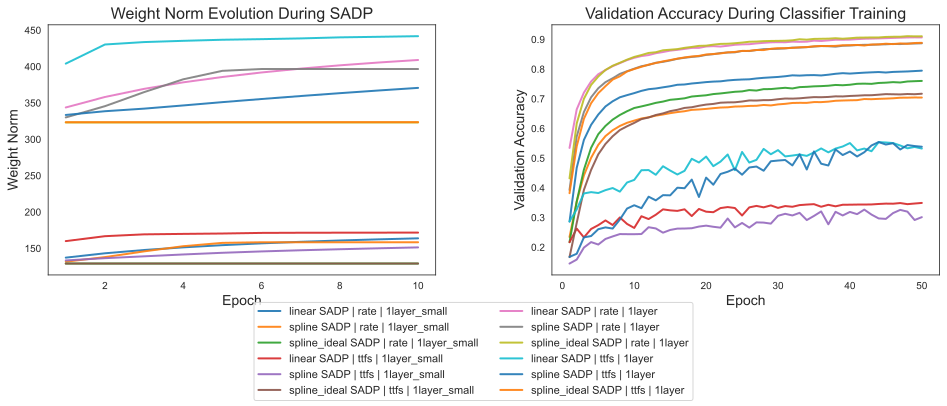

In [5]:
# SUMMARY TABLE (pandas)
df = pd.DataFrame([{
    'Model': r['Model'],
    'Coding': r['Coding'],
    'Classifier': r['Classifier'],
    'Accuracy': r['Accuracy'],
    'F1': r['F1'],
    'Runtime_sec': r['Runtime_sec']
} for r in all_results])

print("\nFinal Benchmark Results:")
print(df.to_markdown(index=False, floatfmt=".4f"))

# save CSV
df.to_csv("sadp_benchmark_results_"+dataset_name+".csv", index=False)

# --- VISUALIZATION: side-by-side plots: weight-norms and val accuracy ---
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# colors from seaborn palette (do not hardcode colors)
palette = sns.color_palette("tab10", n_colors=len(all_results))

for i, r in enumerate(all_results):
    label = f"{r['Model']} | {r['Coding']} | {r['Classifier']}"
    # plot weight norms (if available)
    wn = np.asarray(r.get('W_norms', []))
    if wn.size > 0:
        axes[0].plot(range(1, len(wn) + 1), wn, label=label, linewidth=2, alpha=0.9)
axes[0].set_title("Weight Norm Evolution During SADP", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Weight Norm", fontsize=14)
axes[0].grid(False)

for i, r in enumerate(all_results):
    label = f"{r['Model']} | {r['Coding']} | {r['Classifier']}"
    hist = r.get('History', {})
    val_acc = hist.get('val_accuracy') or hist.get('val_acc') or hist.get('accuracy')  # try common keys
    if val_acc:
        axes[1].plot(range(1, len(val_acc) + 1), val_acc, label=label, linewidth=2, alpha=0.9)
axes[1].set_title("Validation Accuracy During Classifier Training", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Validation Accuracy", fontsize=14)
axes[1].grid(False)

# shared legend
fig.legend(
    handles=axes[0].lines + axes[1].lines,
    labels=[f"{r['Model']} | {r['Coding']} | {r['Classifier']}" for r in all_results],
    loc="lower center",
    fontsize=11,
    frameon=True,
    ncol=2
)
plt.subplots_adjust(bottom=0.30, wspace=0.3)
plt.savefig("training_plots_side_by_side_"+dataset_name+".png", dpi=300, bbox_inches='tight')
plt.show()
